## Work Notebook for Requirements Engineering Journal Article

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from patsy import dmatrices
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms

from research_utils.utils import glm_marginal_effect, compute_pca, calc_total_effect, prep_data

In [3]:
all_data = prep_data()

In [4]:
base_columns = ['crowd_pct', 'crowd_pct_2',
                'avg_clustering', 'avg_min_path', 'gini_coefficient',
                'avg_clusteringXcrowd_pct', 'avg_min_pathXcrowd_pct', 'gini_coefficientXcrowd_pct',
                'total_contributors', 'project_age']
base_features = ' + '.join(base_columns)

### Exploratory Data Analysis

(0, 1)

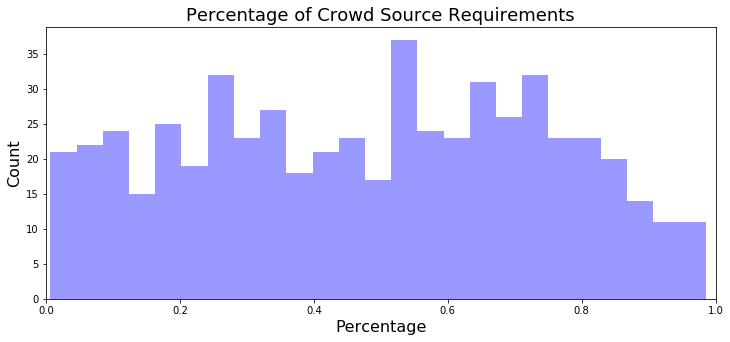

In [5]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['crowd_pct'], kde=False, color='blue', bins=25)
plt.title('Percentage of Crowd Source Requirements', fontsize=18)
plt.xlabel('Percentage', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([0, 1])

(1, 10)

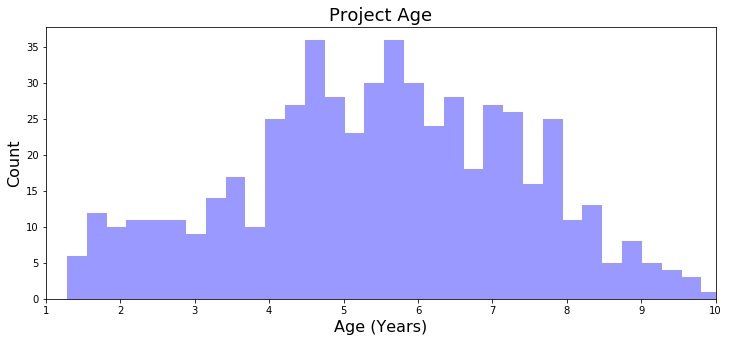

In [6]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['project_age']/365, kde=False, color='blue', bins=54)
plt.title('Project Age', fontsize=18)
plt.xlabel('Age (Years)', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([1, 10])

(1, 40)

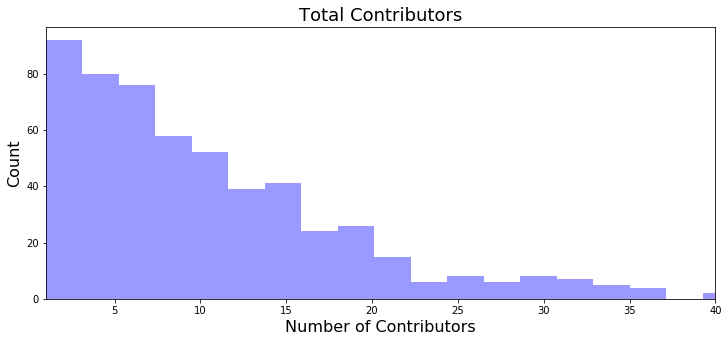

In [7]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['total_contributors'], kde=False, color='blue', bins=40)
plt.title('Total Contributors', fontsize=18)
plt.xlabel('Number of Contributors', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([1, 40])

(1, 150)

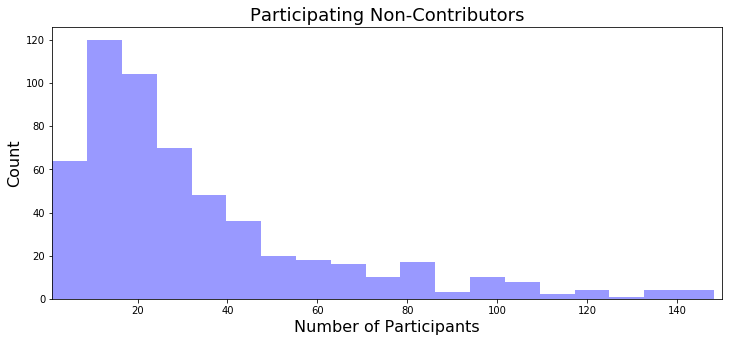

In [8]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['num_users'], kde=False, color='blue', bins=40)
plt.title('Participating Non-Contributors', fontsize=18)
plt.xlabel('Number of Participants', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([1, 150])

(30, 600)

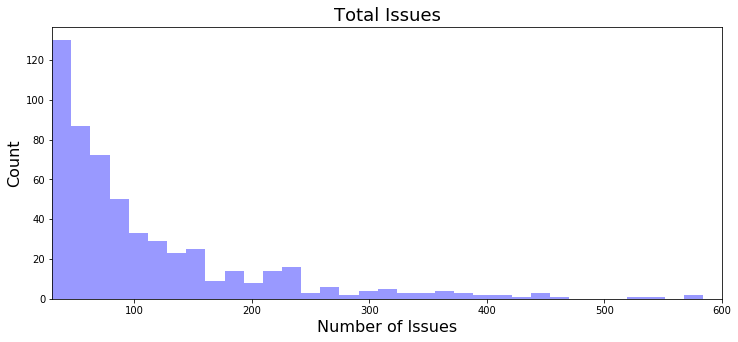

In [9]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['total_issues'], kde=False, color='blue', bins=100)
plt.title('Total Issues', fontsize=18)
plt.xlabel('Number of Issues', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([30, 600])

In [10]:
all_data[['crowd_pct', 'project_age', 'total_contributors', 'num_users', 'total_issues']].describe()

,crowd_pct,project_age,total_contributors,num_users,total_issues
count,562.000000,562.000000,562.000000,562.000000,562.000000
mean,0.480865,2009.028470,11.539146,34.213523,119.026690
std,0.263940,708.744303,10.587185,32.851103,128.293396
min,0.006711,468.000000,1.000000,1.000000,30.000000
25%,0.265306,1565.000000,5.000000,14.000000,48.250000
50%,0.500000,2028.000000,9.000000,24.000000,77.000000
75%,0.699603,2525.750000,15.000000,42.000000,141.750000
max,0.985294,5721.000000,86.000000,311.000000,1660.000000


In [11]:
(all_data['project_age'] / 365).describe()

count    562.000000
mean       5.504188
std        1.941765
min        1.282192
25%        4.287671
50%        5.556164
75%        6.919863
max       15.673973
Name: project_age, dtype: float64

(0, 1)

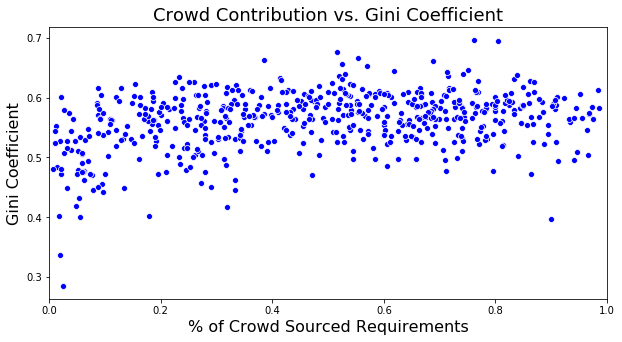

In [12]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=all_data['crowd_pct'], y=all_data['gini_coefficient'], color='blue')
plt.title('Crowd Contribution vs. Gini Coefficient', fontsize=18)
plt.xlabel('% of Crowd Sourced Requirements', fontsize=16)
plt.ylabel('Gini Coefficient', fontsize=16)
plt.xlim([0,1])

Text(0, 0.5, 'Avg Min Path')

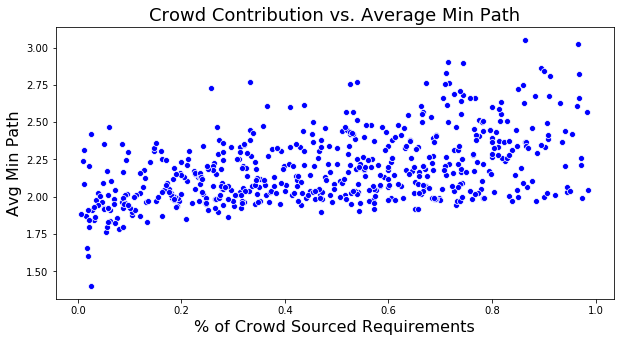

In [13]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=all_data['crowd_pct'], y=all_data['avg_min_path'], color='blue')
plt.title('Crowd Contribution vs. Average Min Path', fontsize=18)
plt.xlabel('% of Crowd Sourced Requirements', fontsize=16)
plt.ylabel('Avg Min Path', fontsize=16)
# plt.xlim([0,1])

Text(0, 0.5, 'Clustering Coef.')

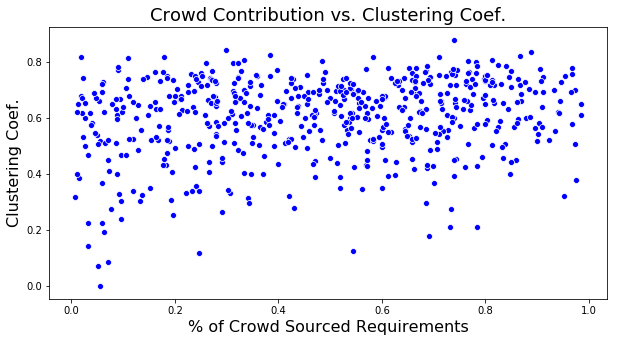

In [14]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=all_data['crowd_pct'], y=all_data['avg_clustering'], color='blue')
plt.title('Crowd Contribution vs. Clustering Coef.', fontsize=18)
plt.xlabel('% of Crowd Sourced Requirements', fontsize=16)
plt.ylabel('Clustering Coef.', fontsize=16)
# plt.xlim([0,1])

In [15]:
all_data[['gini_coefficient', 'avg_min_path', 'avg_clustering']].describe()

,gini_coefficient,avg_min_path,avg_clustering
count,562.000000,562.000000,562.000000
mean,0.561907,2.187393,0.601003
std,0.048177,0.232263,0.140855
min,0.285714,1.400000,0.000000
25%,0.535522,2.012390,0.522477
50%,0.568641,2.145767,0.627541
75%,0.592101,2.331743,0.704530
max,0.696200,3.054147,0.878524


### Regression on Average Comments

Text(0, 0.5, 'Count')

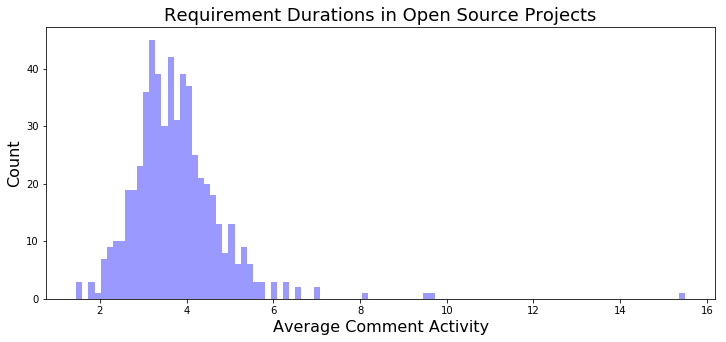

In [16]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['avg_comments'], kde=False, color='blue', bins=100)
plt.title('Requirement Durations in Open Source Projects', fontsize=18)
plt.xlabel('Average Comment Activity', fontsize=16)
plt.ylabel('Count', fontsize=16)

In [17]:
all_data['avg_comments'].describe()

count    562.000000
mean       3.766143
std        1.079171
min        1.457227
25%        3.148360
50%        3.629720
75%        4.223124
max       15.493750
Name: avg_comments, dtype: float64

In [18]:
formula = """
avg_comments ~ crowd_pct + crowd_pct_2 + avg_clustering + 
    avg_min_path + gini_coefficient + avg_clusteringXcrowd_pct + 
    avg_min_pathXcrowd_pct + gini_coefficientXcrowd_pct + project_age +
    topic_0 + topic_1 + topic_2 + topic_3 + topic_4 + topic_5 + 
    topic_6 + topic_7 + topic_8 + topic_9 + topic_10 + topic_11 + 
    topic_12 + topic_13 + topic_14 + topic_15 + topic_16 + topic_17 + 
    topic_18 + topic_19 + topic_20 + topic_21 + topic_22 + topic_23 + 
    topic_0:topic_1 + topic_0:topic_7 + topic_0:topic_9 + topic_0:topic_10 + 
    topic_0:topic_18 + topic_0:topic_19 + topic_0:topic_21 + 
    topic_1:topic_2 + topic_1:topic_9 + topic_1:topic_10 + topic_1:topic_13 + 
    topic_1:topic_14 + topic_1:topic_21 + topic_2:topic_11 + 
    topic_2:topic_12 + topic_2:topic_18 + topic_2:topic_20 + 
    topic_2:topic_22 + topic_3:topic_5 + topic_3:topic_11 + topic_3:topic_21 + 
    topic_4:topic_8 + topic_4:topic_18 + topic_5:topic_7 + topic_5:topic_9 + 
    topic_5:topic_11 + topic_5:topic_15 + topic_5:topic_17 + 
    topic_5:topic_22 + topic_6:topic_7 + topic_6:topic_8 + topic_6:topic_12 + 
    topic_6:topic_14 + topic_6:topic_16 + topic_6:topic_17 + 
    topic_6:topic_18 + topic_6:topic_19 + topic_7:topic_8 + topic_7:topic_16 + 
    topic_7:topic_23 + topic_8:topic_9 + topic_8:topic_15 + topic_9:topic_10 + 
    topic_9:topic_16 + topic_9:topic_19 + topic_9:topic_20 + 
    topic_9:topic_22 + topic_10:topic_12 + topic_10:topic_16 + 
    topic_10:topic_20 + topic_10:topic_22 + topic_10:topic_23 + 
    topic_11:topic_13 + topic_11:topic_14 + topic_11:topic_15 + 
    topic_11:topic_16 + topic_11:topic_17 + topic_11:topic_22 + 
    topic_14:topic_17 + topic_14:topic_20 + topic_14:topic_22 + 
    topic_15:topic_16 + topic_15:topic_18 + topic_15:topic_21 + 
    topic_16:topic_19 + topic_16:topic_22 + topic_17:topic_18 + 
    topic_17:topic_20 + topic_17:topic_22 + topic_18:topic_23 + 
    topic_19:topic_20 + topic_19:topic_21 + topic_19:topic_23 + 
    topic_20:topic_21 + topic_21:topic_22 + topic_3:topic_8 + 
    topic_7:topic_18 + topic_5:topic_12

"""
y, X = dmatrices(formula,
                 data=all_data, return_type='dataframe')
X = compute_pca(X, 80)
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

2020-01-29 00:24:58,594 [11507] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.



0.5232496861611933
90
                 Generalized Linear Model Regression Results                  
Dep. Variable:           avg_comments   No. Observations:                  562
Model:                            GLM   Df Residuals:                      472
Model Family:                   Gamma   Df Model:                           89
Link Function:                    log   Scale:                        0.042318
Method:                          IRLS   Log-Likelihood:                -569.88
Date:                Wed, 29 Jan 2020   Deviance:                       18.101
Time:                        00:24:58   Pearson chi2:                     20.0
No. Iterations:                    16                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [19]:
network_factors = ['avg_clustering', 'avg_min_path', 'gini_coefficient']
for factor in network_factors:
    effect = glm_marginal_effect(factor, res, X, all_data)
    print('{}: {}'.format(factor, effect))

avg_clustering: 2.417207257331044
avg_min_path: -1.867475095773142
gini_coefficient: 4.918940029217601


In [20]:
calc_total_effect(all_data, res, X)

0.1635822318607801

2020-01-29 00:25:02,107 [11507] WARNING  matplotlib.legend: No handles with labels found to put in legend.


Text(0.5, 0, 'Crowd Pct')

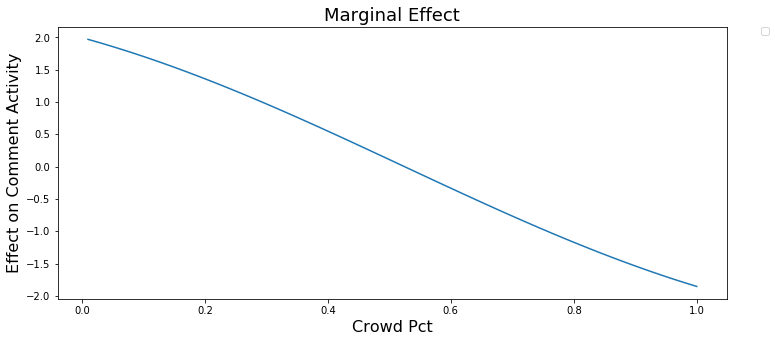

In [21]:
plt.figure(figsize=(12, 5))

marginal_effects = {'crowd_pct': [], 'effect': []}
avg_min_path = all_data['avg_min_path']
gini_coefficient = all_data['gini_coefficient']
avg_clustering = all_data['avg_clustering']

for i in range(100):
    crowd_pct = (i+1)/100
    avg_effect = calc_total_effect(all_data, res, X, crowd_pct=crowd_pct)
    marginal_effects['crowd_pct'].append(crowd_pct)
    marginal_effects['effect'].append(avg_effect)
        
marginal_effects = pd.DataFrame(marginal_effects)
sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Comment Activity', fontsize=16)
plt.xlabel('Crowd Pct', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

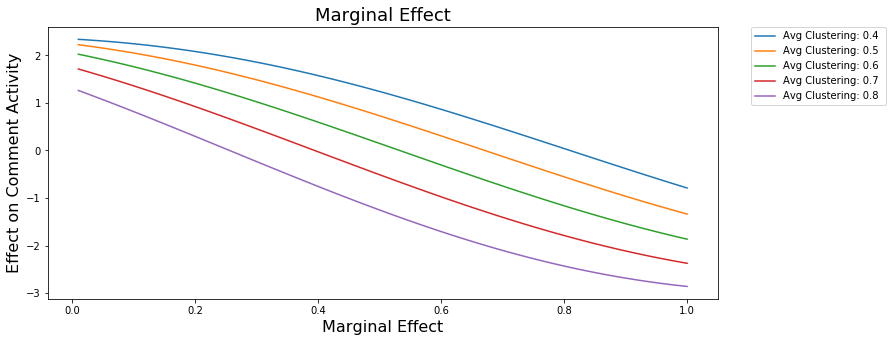

In [22]:
plt.figure(figsize=(12, 5))

for avg_clustering in [0.4, 0.5, 0.6, 0.7, 0.8]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Clustering: {} '.format(avg_clustering)

    for i in range(100):
        crowd_pct = (i+1)/100
        avg_effect = calc_total_effect(all_data, res, X,
                                       crowd_pct=crowd_pct, 
                                       avg_clustering=avg_clustering)
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)

    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Comment Activity', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

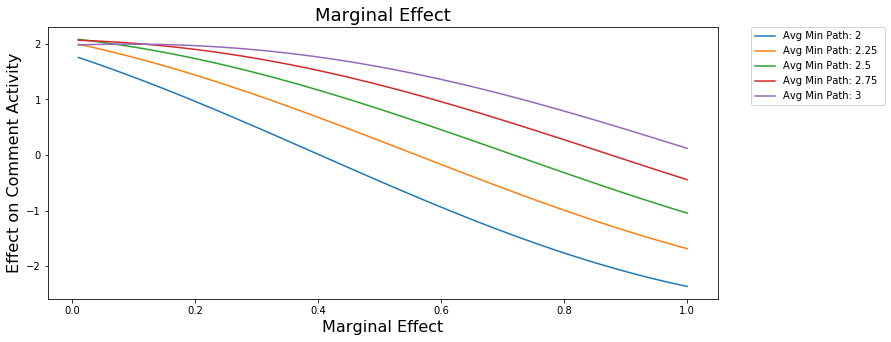

In [23]:
plt.figure(figsize=(12, 5))

for avg_min_path in [2, 2.25, 2.5, 2.75, 3]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Min Path: {} '.format(avg_min_path)

    for i in range(100):
        crowd_pct = (i+1)/100
        avg_effect = calc_total_effect(all_data, res, X,
                                       crowd_pct=crowd_pct, 
                                       avg_min_path=avg_min_path)
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Comment Activity', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

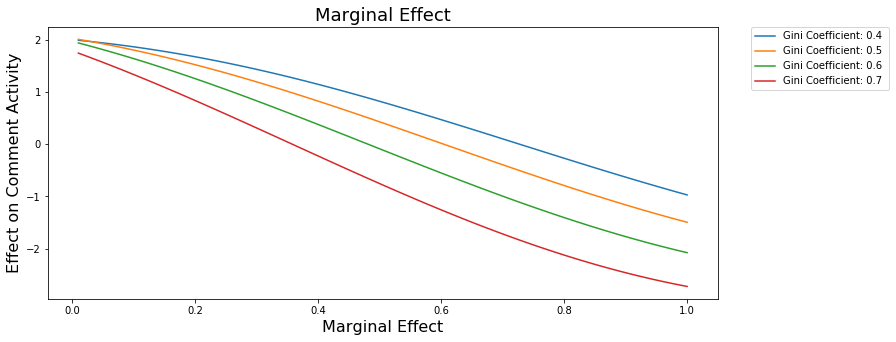

In [24]:
plt.figure(figsize=(12, 5))

for gini_coefficient in [0.4, 0.5, 0.6, 0.7]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Gini Coefficient: {} '.format(gini_coefficient)
    avg_clustering = all_data['avg_clustering']
    avg_min_path = all_data['avg_min_path']

    for i in range(100):
        crowd_pct = (i+1)/100
        avg_effect = calc_total_effect(all_data, res, X,
                                       crowd_pct=crowd_pct, 
                                       gini_coefficient=gini_coefficient)
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Comment Activity', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

### Regression on Issues Submitted Over Time

(0, 40)

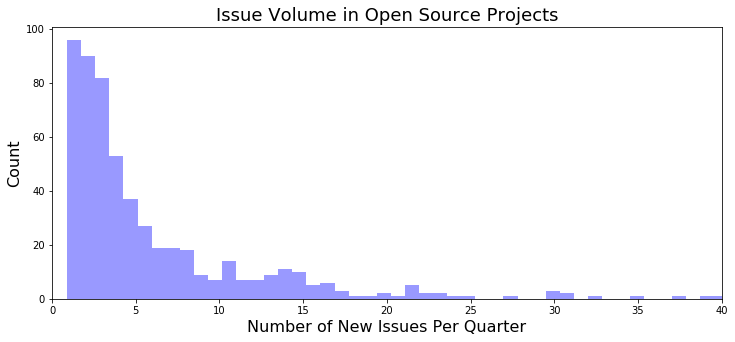

In [25]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['issues_over_time'], kde=False, color='blue', bins=100)
plt.title('Issue Volume in Open Source Projects', fontsize=18)
plt.xlabel('Number of New Issues Per Quarter', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([0, 40])

In [26]:
all_data['issues_over_time'].describe()

count    562.000000
mean       6.532880
std        8.348033
min        0.901202
25%        2.154523
50%        3.593717
75%        7.548407
max       84.975369
Name: issues_over_time, dtype: float64

In [27]:
formula = """
issues_over_time ~ crowd_pct + crowd_pct_2 + avg_clustering + 
    avg_min_path + gini_coefficient + avg_clusteringXcrowd_pct + 
    avg_min_pathXcrowd_pct + gini_coefficientXcrowd_pct + total_contributors + 
    project_age
"""
y, X = dmatrices(formula,
                 data=all_data, return_type='dataframe')
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

2020-01-29 00:25:47,443 [11507] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  if __name__ == '__main__':



0.6613430781735086
11
                 Generalized Linear Model Regression Results                  
Dep. Variable:       issues_over_time   No. Observations:                  562
Model:                            GLM   Df Residuals:                      551
Model Family:                   Gamma   Df Model:                           10
Link Function:                    log   Scale:                         0.39904
Method:                          IRLS   Log-Likelihood:                -1293.9
Date:                Wed, 29 Jan 2020   Deviance:                       169.07
Time:                        00:25:47   Pearson chi2:                     220.
No. Iterations:                    26                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [28]:
network_factors = ['avg_clustering', 'avg_min_path', 'gini_coefficient']
for factor in network_factors:
    effect = glm_marginal_effect(factor, res, X, all_data)
    print('{}: {}'.format(factor, effect))

avg_clustering: -3.833244128274739
avg_min_path: -0.16296451670706222
gini_coefficient: 22.819708227746496


In [29]:
calc_total_effect(all_data, res, X)

-5.811775501937335

2020-01-29 00:25:49,947 [11507] WARNING  matplotlib.legend: No handles with labels found to put in legend.


Text(0.5, 0, 'Crowd Pct')

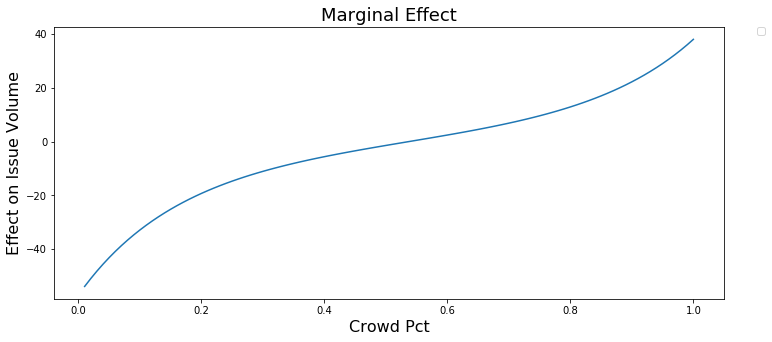

In [30]:
plt.figure(figsize=(12, 5))

marginal_effects = {'crowd_pct': [], 'effect': []}
avg_min_path = all_data['avg_min_path']
gini_coefficient = all_data['gini_coefficient']
avg_clustering = all_data['avg_clustering']

for i in range(100):
    crowd_pct = (i+1)/100
    avg_effect = calc_total_effect(all_data, res, X, crowd_pct=crowd_pct)
    marginal_effects['crowd_pct'].append(crowd_pct)
    marginal_effects['effect'].append(avg_effect)
        
marginal_effects = pd.DataFrame(marginal_effects)
sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Issue Volume', fontsize=16)
plt.xlabel('Crowd Pct', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

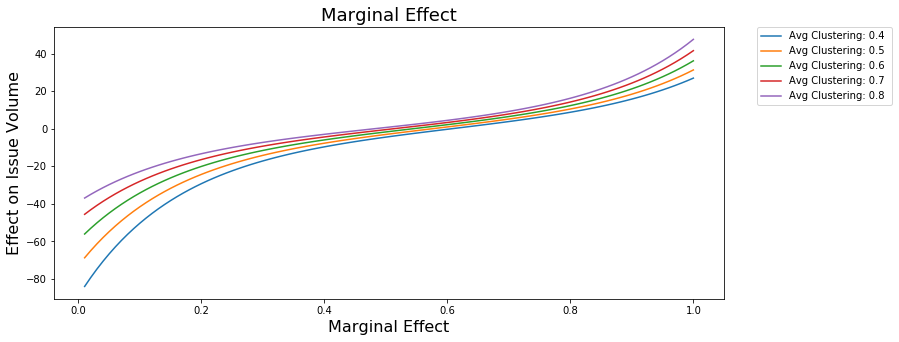

In [31]:
plt.figure(figsize=(12, 5))

for avg_clustering in [0.4, 0.5, 0.6, 0.7, 0.8]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Clustering: {} '.format(avg_clustering)

    for i in range(100):
        crowd_pct = (i+1)/100
        avg_effect = calc_total_effect(all_data, res, X,
                                       crowd_pct=crowd_pct, 
                                       avg_clustering=avg_clustering)
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)

    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Issue Volume', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

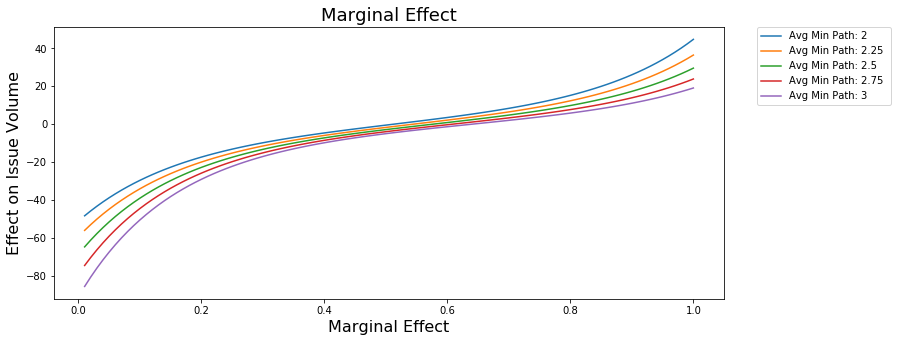

In [32]:
plt.figure(figsize=(12, 5))

for avg_min_path in [2, 2.25, 2.5, 2.75, 3]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Min Path: {} '.format(avg_min_path)

    for i in range(100):
        crowd_pct = (i+1)/100
        avg_effect = calc_total_effect(all_data, res, X,
                                       crowd_pct=crowd_pct, 
                                       avg_min_path=avg_min_path)
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Issue Volume', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

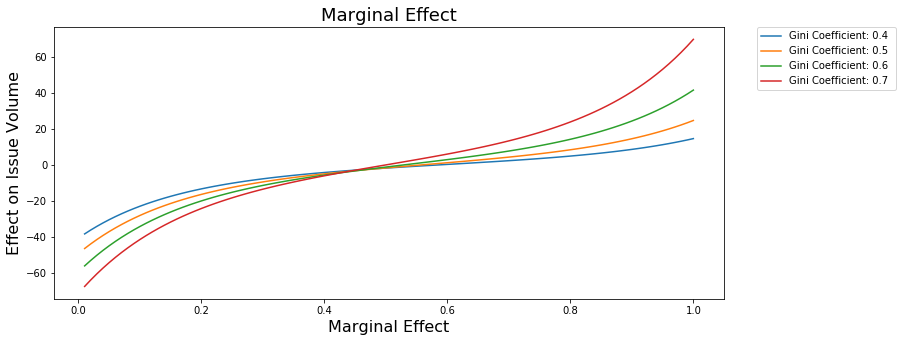

In [33]:
plt.figure(figsize=(12, 5))

for gini_coefficient in [0.4, 0.5, 0.6, 0.7]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Gini Coefficient: {} '.format(gini_coefficient)

    for i in range(100):
        crowd_pct = (i+1)/100
        avg_effect = calc_total_effect(all_data, res, X,
                                       crowd_pct=crowd_pct, 
                                       gini_coefficient=gini_coefficient)
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Issue Volume', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

### Avg First Comment Time

In [34]:
all_data['avg_first_comment'].describe()

count    562.000000
mean      29.004449
std       37.018716
min        0.169014
25%        8.695482
50%       18.767917
75%       35.140768
max      389.746114
Name: avg_first_comment, dtype: float64

(0, 150)

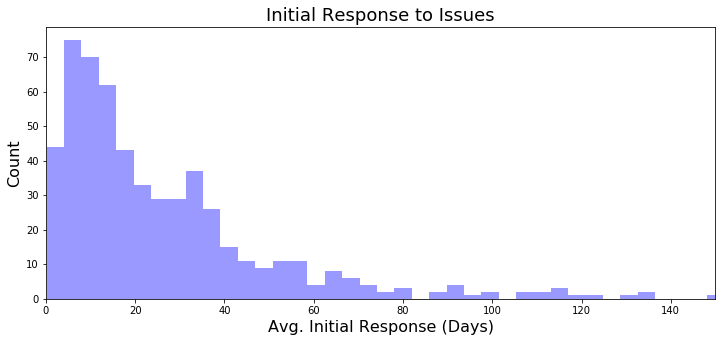

In [35]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['avg_first_comment'], kde=False, color='blue', bins=100)
plt.title('Initial Response to Issues', fontsize=18)
plt.xlabel('Avg. Initial Response (Days)', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([0, 150])

In [50]:
formula = """
avg_first_comment ~ crowd_pct + crowd_pct_2 + avg_clustering + 
    avg_clusteringXcrowd_pct + avg_min_pathXcrowd_pct + gini_coefficient + gini_coefficientXcrowd_pct + 
    project_age
"""
y, X = dmatrices(formula,
                 data=all_data, return_type='dataframe')
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

2020-01-29 00:28:03,554 [11507] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  



0.41136415196561893
9
                 Generalized Linear Model Regression Results                  
Dep. Variable:      avg_first_comment   No. Observations:                  562
Model:                            GLM   Df Residuals:                      553
Model Family:                   Gamma   Df Model:                            8
Link Function:                    log   Scale:                         0.77195
Method:                          IRLS   Log-Likelihood:                -2300.6
Date:                Wed, 29 Jan 2020   Deviance:                       352.74
Time:                        00:28:03   Pearson chi2:                     427.
No. Iterations:                    15                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [51]:
network_factors = ['avg_clustering', 'gini_coefficient']
for factor in network_factors:
    effect = glm_marginal_effect(factor, res, X, all_data)
    print('{}: {}'.format(factor, effect))

avg_clustering: 25.335996966360035
gini_coefficient: -179.0893596193125


In [52]:
calc_total_effect(all_data, res, X)

8.351517170036077

2020-01-29 00:28:06,930 [11507] WARNING  matplotlib.legend: No handles with labels found to put in legend.


Text(0.5, 0, 'Crowd Pct')

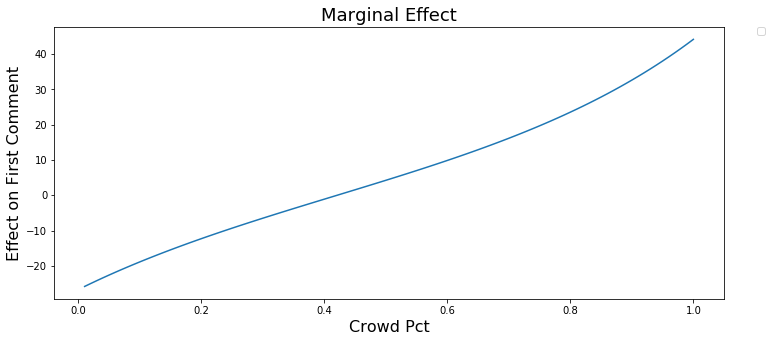

In [53]:
plt.figure(figsize=(12, 5))

marginal_effects = {'crowd_pct': [], 'effect': []}
avg_min_path = all_data['avg_min_path']
gini_coefficient = all_data['gini_coefficient']
avg_clustering = all_data['avg_clustering']

for i in range(100):
    crowd_pct = (i+1)/100
    avg_effect = calc_total_effect(all_data, res, X, crowd_pct=crowd_pct)
    marginal_effects['crowd_pct'].append(crowd_pct)
    marginal_effects['effect'].append(avg_effect)
        
marginal_effects = pd.DataFrame(marginal_effects)
sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on First Comment', fontsize=16)
plt.xlabel('Crowd Pct', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

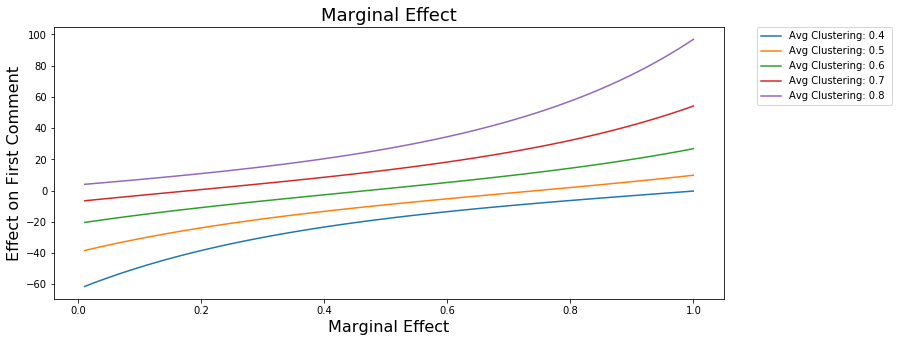

In [54]:
plt.figure(figsize=(12, 5))

for avg_clustering in [0.4, 0.5, 0.6, 0.7, 0.8]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Clustering: {} '.format(avg_clustering)

    for i in range(100):
        crowd_pct = (i+1)/100
        avg_effect = calc_total_effect(all_data, res, X,
                                       crowd_pct=crowd_pct, 
                                       avg_clustering=avg_clustering)
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)

    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on First Comment', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

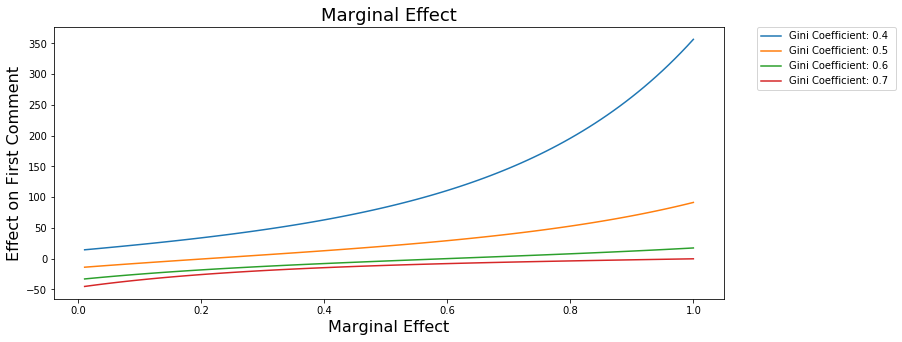

In [55]:
plt.figure(figsize=(12, 5))

for gini_coefficient in [0.4, 0.5, 0.6, 0.7]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Gini Coefficient: {} '.format(gini_coefficient)

    for i in range(100):
        crowd_pct = (i+1)/100
        avg_effect = calc_total_effect(all_data, res, X,
                                       crowd_pct=crowd_pct, 
                                       gini_coefficient=gini_coefficient)
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on First Comment', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

### Issues Per User

In [41]:
all_data['issues_per_user'].describe()

count    562.000000
mean       5.422194
std        8.544846
min        1.113402
25%        2.192618
50%        3.177866
75%        5.174578
max       97.000000
Name: issues_per_user, dtype: float64

(0, 40)

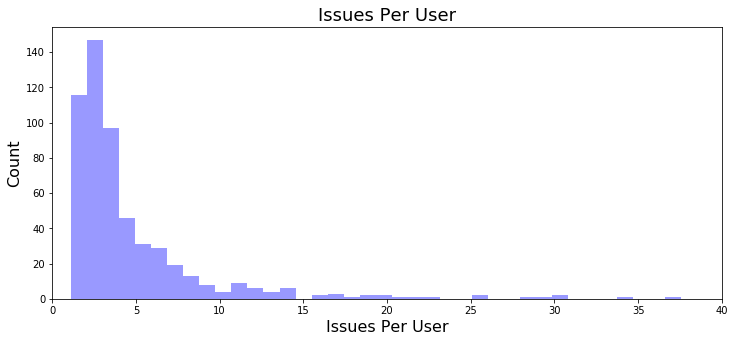

In [42]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['issues_per_user'], kde=False, color='blue', bins=100)
plt.title('Issues Per User', fontsize=18)
plt.xlabel('Issues Per User', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([0, 40])

In [43]:
formula = """
issues_per_user ~ crowd_pct + crowd_pct_2 + avg_min_path + 
    gini_coefficient + gini_coefficientXcrowd_pct 
"""
y, X = dmatrices(formula,
                 data=all_data, return_type='dataframe')
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

2020-01-29 00:26:34,678 [11507] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  import sys



0.645577627340495
6
                 Generalized Linear Model Regression Results                  
Dep. Variable:        issues_per_user   No. Observations:                  562
Model:                            GLM   Df Residuals:                      556
Model Family:                   Gamma   Df Model:                            5
Link Function:                    log   Scale:                         0.67543
Method:                          IRLS   Log-Likelihood:                -1284.5
Date:                Wed, 29 Jan 2020   Deviance:                       153.48
Time:                        00:26:34   Pearson chi2:                     376.
No. Iterations:                    29                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------


In [44]:
glm_marginal_effect('avg_min_path', res, X, all_data)

3.0108534148009145

In [45]:
calc_total_effect(all_data, res, X)

-19.11782332424723

### Average Active Time

In [46]:
all_data['avg_active_time'].describe()

count    562.000000
mean      68.128883
std       52.051931
min        0.675000
25%       31.744782
50%       55.716894
75%       88.387924
max      531.482618
Name: avg_active_time, dtype: float64

In [47]:
formula = """
avg_active_time ~ crowd_pct + avg_min_path + avg_clusteringXcrowd_pct + 
    avg_min_pathXcrowd_pct + gini_coefficientXcrowd_pct + project_age + 
    nodes + avg_clustering + gini_coefficient
"""
y, X = dmatrices(formula,
                 data=all_data, return_type='dataframe')
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

2020-01-29 00:26:35,394 [11507] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  



0.5139248844634483
10
                 Generalized Linear Model Regression Results                  
Dep. Variable:        avg_active_time   No. Observations:                  562
Model:                            GLM   Df Residuals:                      552
Model Family:                   Gamma   Df Model:                            9
Link Function:                    log   Scale:                         0.29994
Method:                          IRLS   Log-Likelihood:                -2661.0
Date:                Wed, 29 Jan 2020   Deviance:                       151.15
Time:                        00:26:35   Pearson chi2:                     166.
No. Iterations:                    18                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [48]:
network_factors = ['avg_clustering', 'avg_min_path', 'gini_coefficient']
for factor in network_factors:
    effect = glm_marginal_effect(factor, res, X, all_data)
    print('{}: {}'.format(factor, effect))

avg_clustering: 121.66119127507577
avg_min_path: 2.908084234892954
gini_coefficient: -201.75431400602804


In [49]:
calc_total_effect(all_data, res)

TypeError: calc_total_effect() missing 1 required positional argument: 'X'

In [ ]:
plt.figure(figsize=(12, 5))

marginal_effects = {'crowd_pct': [], 'effect': []}
for i in range(100):
    crowd_pct = (i+1)/100
    avg_effect = calc_total_effect(all_data, res, X, crowd_pct=crowd_pct)
    marginal_effects['crowd_pct'].append(crowd_pct)
    marginal_effects['effect'].append(avg_effect)
        
marginal_effects = pd.DataFrame(marginal_effects)
sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Active Time', fontsize=16)
plt.xlabel('Crowd Pct', fontsize=16)

In [ ]:
plt.figure(figsize=(12, 5))

for avg_min_path in [2, 2.25, 2.5, 2.75, 3]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Min Path: {} '.format(avg_min_path)

    for i in range(100):
        crowd_pct = (i+1)/100
        avg_effect = calc_total_effect(all_data, res, X,
                                       crowd_pct=crowd_pct, 
                                       avg_min_path=avg_min_path)
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Active Time', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

In [ ]:
plt.figure(figsize=(12, 5))

for avg_min_path in [2, 2.25, 2.5, 2.75, 3]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Min Path: {} '.format(avg_min_path)

    for i in range(100):
        crowd_pct = (i+1)/100
        avg_effect = calc_total_effect(all_data, res, X,
                                       crowd_pct=crowd_pct, 
                                       avg_min_path=avg_min_path)
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Active Time', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)